In [7]:
import torch
import torch.nn as nn
import numpy as np
from spikingjelly.activation_based import functional, learning, neuron

In [8]:
n_in = 1
n_out = 1
T = 10

net = nn.Sequential(
    nn.Linear(n_in, n_out, bias=False),
    neuron.IFNode()
)

net[0].weight.data = nn.init.normal_(net[0].weight.data, mean=0.8, std=0.1)

net

Sequential(
  (0): Linear(in_features=1, out_features=1, bias=False)
  (1): IFNode(
    v_threshold=1.0, v_reset=0.0, detach_reset=False, step_mode=s, backend=torch
    (surrogate_function): Sigmoid(alpha=4.0, spiking=True)
  )
)

In [9]:
s_pre = torch.ones((T,n_in, n_out))
s_pre.shape

torch.Size([10, 1, 1])

In [10]:
net(s_pre)

tensor([[[0.]],

        [[0.]],

        [[0.]],

        [[0.]],

        [[0.]],

        [[0.]],

        [[0.]],

        [[0.]],

        [[0.]],

        [[0.]]], grad_fn=<sigmoidBackward>)

In [11]:
functional.reset_net(net)

In [12]:
# Weight control for Long Term Potentiation (LTP)
def f_pre(x):
    return torch.clamp(x,0,0.02)

# Weight control for Long Term Depression (LTD)
def f_post(x):
    return torch.clamp(x,0,0.08)

# Define STDP Learner
learner = learning.STDPLearner(
    step_mode='s',
    synapse=net[0],
    sn=net[1],
    tau_pre=2,
    tau_post=2,
    f_pre=f_pre,
    f_post=f_post
)

# Define Optimizer for STDP
stdp_optimizer = torch.optim.SGD(net[0].parameters(), lr=1, momentum=0.)

In [13]:
s_post = []
w = []
trace_pre = []
trace_post = []
potential = []

for t in range(T):
    s_post.append(net(s_pre[t]).detach().numpy().squeeze(0))
    stdp_optimizer.step()
    learner.step(on_grad=True)

    trace_post.append(learner.trace_post.item())
    trace_pre.append(learner.trace_pre.item())
    w.append(net[0].weight.item())
    potential.append(net[1].v.detach().numpy().squeeze(0))

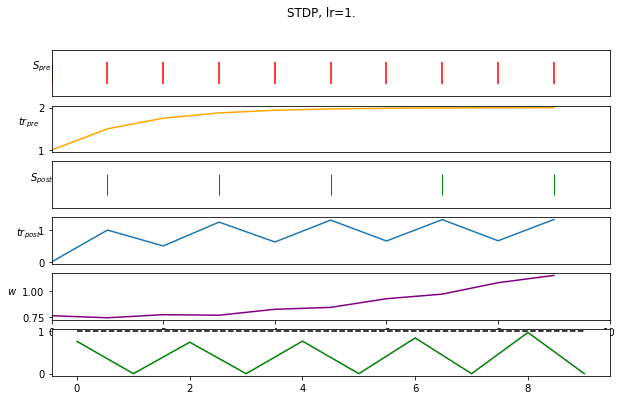

In [14]:
import matplotlib.pyplot as plt

threshold=1

fig = plt.figure(figsize=(10, 6))
plt.suptitle("STDP, lr=1.")

s_pre = s_pre[:, 0].numpy()
s_post = np.array(s_post)

t = np.arange(0, T)
plt.subplot(6, 1, 1)
plt.eventplot((t * s_pre[:, 0])[s_pre[:, 0] == 1.], lineoffsets=0, colors='r')
plt.yticks([])
plt.ylabel('$S_{pre}$', rotation=0, labelpad=10)
plt.xticks([])
plt.xlim(0, T)
plt.subplot(6, 1, 2)
plt.plot(t, trace_pre, c='orange')
plt.ylabel('$tr_{pre}$', rotation=0, labelpad=10)
plt.xticks([])
plt.xlim(0, T)

plt.subplot(6, 1, 3)
spike_times = [i for i, x in enumerate(s_post[:]) if x == 1]
plt.eventplot(spike_times,lineoffsets=0, linewidths=1., colors='g', label="neuron2")
plt.yticks([])
plt.ylabel('$S_{post}$', rotation=0, labelpad=10)
plt.xticks([])
plt.xlim(0, T)
plt.subplot(6, 1, 4)
plt.plot(t, trace_post)
plt.ylabel('$tr_{post}$', rotation=0, labelpad=10)
plt.xticks([])
plt.xlim(0, T)
plt.subplot(6, 1, 5)
plt.plot(t, w, c='purple')
plt.ylabel('$w$', rotation=0, labelpad=10)
plt.xlim(0, T)
plt.subplot(6,1,6)
plt.plot(potential, c='green')
plt.plot([0., T-1], [threshold, threshold], "k--", label="threshold")

plt.show()